# OpenServer Functions

## Modules

In [16]:
import win32com.client
import sys
import time
import os

## Functions

In [17]:
class OpenServer():
    "Class for holding ActiveX reference. Allows license disconnection"
    def __init__(self):
        self.status = "Disconnected"
        self.OSReference = None
    
    def Connect(self):
        self.OSReference = win32com.client.Dispatch("PX32.OpenServer.1")
        self.status = "Connected"
        print("OpenServer connected")
        
    def Disconnect(self):
        self.OSReference = None
        self.status = "Disconnected"
        print("OpenServer disconnected")

In [18]:
def GetAppName(sv):
    # function for returning app name from tag string
    pos = sv.find(".")
    if pos < 2:
        sys.exit("GetAppName: Badly formed tag string")
    app_name = sv[:pos]
    if app_name.lower() not in ["prosper", "mbal", "gap", "pvt", "resolve",
                                   "reveal"]:
        sys.exit("GetAppName: Unrecognised application name in tag string")
    return app_name


def DoCmd(OpenServe, cmd):
    # perform a command and check for errors
    lerr = OpenServe.OSReference.DoCommand(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoCmd: " + err)


def DoSet(OpenServe, sv, val):
    # set a value and check for errors
    lerr = OpenServe.OSReference.SetValue(sv, val)
    app_name = GetAppName(sv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSet: " + err)
    
def DoGet(OpenServe, gv):
    # get a value and check for errors
    get_value = OpenServe.OSReference.GetValue(gv)
    app_name = GetAppName(gv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGet: " + err)
    return get_value


def DoSlowCmd(OpenServe, cmd):
    # perform a command then wait for command to exit and check for errors
    step = 0.001
    app_name = GetAppName(cmd)
    lerr = OpenServe.OSReference.DoCommandAsync(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)
    while OpenServe.OSReference.IsBusy(app_name) > 0:
        if step < 2:
            step = step*2
        time.sleep(step)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)


def DoGAPFunc(OpenServe, gv):
    DoSlowCmd(gv)
    DoGAPFunc = DoGet(OpenServe, "GAP.LASTCMDRET")
    lerr = OpenServe.OSReference.GetLastError("GAP")
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGAPFunc: " + err)
    return DoGAPFunc


def OSOpenFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.OPENFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSOpenFile: " + err)


def OSSaveFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.SAVEFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSSaveFile: " + err)

In [19]:
# Import modules for plotting and handling data
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm

# Import input distributions as required
from scipy.stats import truncnorm
from scipy.stats import triang
from scipy.stats import uniform

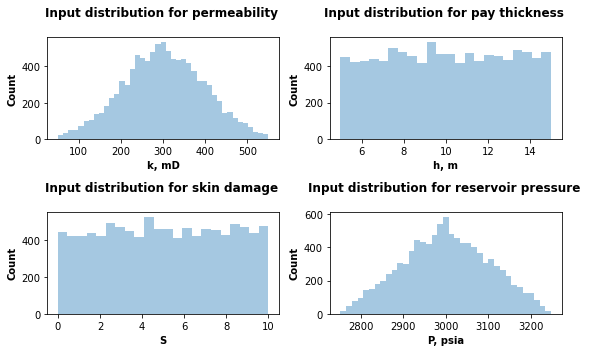

In [20]:
# Define a random number seed for reproducible results

seed = 123456
n_trials = 10000


# Set up plot grid for inputs

fig, axs = plt.subplots(2,2, figsize=[8,5])


# Permeability input will be normally distributed, truncated to the range 50 mD - 550 mD
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

a, b = (50 - 300) / 100, (550 - 300) / 100
perm_dist = truncnorm.rvs(a, b, loc = 300, scale = 100, size = n_trials, random_state = seed)
ax = sns.distplot(perm_dist, kde = False, ax=axs[0,0])
axs[0,0].set_title("Input distribution for permeability \n", fontweight = 'bold')
ax.set_ylabel("Count", fontweight = 'bold')
ax.set_xlabel("k, mD", fontweight = 'bold')


# Net pay thickness will be uniformly distributed
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html

pay_dist = uniform.rvs(loc = 5, scale = 10, size = n_trials, random_state = seed)
ax = sns.distplot(pay_dist, kde = False, ax=axs[0,1])
axs[0,1].set_title("Input distribution for pay thickness \n", fontweight = 'bold')
ax.set_ylabel("Count", fontweight = 'bold')
ax.set_xlabel("h, m", fontweight = 'bold')


# Skin will be uniformly distributed

skin_dist = uniform.rvs(loc = 0, scale = 10, size = n_trials, random_state = seed)
ax = sns.distplot(skin_dist, kde = False, ax=axs[1,0])
axs[1,0].set_title("Input distribution for skin damage \n", fontweight = 'bold')
ax.set_ylabel("Count", fontweight = 'bold')
ax.set_xlabel("S", fontweight = 'bold')


# Reservoir pressure will be use the triangular distribution
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html

pres_dist = triang.rvs(c = 0.5, loc = 2750, scale = 500, size = n_trials, random_state = seed)
ax = sns.distplot(pres_dist, kde = False, ax=axs[1,1])
axs[1,1].set_title("Input distribution for reservoir pressure \n", fontweight = 'bold')
ax.set_ylabel("Count", fontweight = 'bold')
ax.set_xlabel("P, psia", fontweight = 'bold')


plt.tight_layout()
plt.show()

In [21]:
# Create a dataframe to hold inputs and results
# See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

df_well_MC = pd.DataFrame({
        'perm' : perm_dist,
        'pay' : pay_dist,
        'skin' : skin_dist,
        'pres' : pres_dist
         })

In [22]:
try:
    # Initialises an 'OpenServer' class

    petex = OpenServer()
    
    # Creates ActiveX reference and holds a license

    petex.Connect()
    
    # Perform functions

    cwd = os.getcwd()
    OSOpenFile(petex, cwd + r'\Example_Well.Out', 'PROSPER')
    DoCmd(petex, 'PROSPER.ANL.SYS.CALC')
    OPR = DoGet(petex, 'PROSPER.OUT.SYS.Results[0].Sol.OilRate')
    OPR = round(float(OPR),0)
    print("""
            Base case oil rate: %s stb/d
          """ % OPR)
  
finally:
    # Required to close the license otherwise remains checked out
    
    petex.Disconnect()

OpenServer disconnected


com_error: (-2147221005, 'Invalid class string', None, None)

In [ ]:
try:
    # Initialises an 'OpenServer' class

    petex = OpenServer()
    
    # Creates ActiveX reference and holds a license

    petex.Connect()
    
    # Perform functions

    cwd = os.getcwd()
    OSOpenFile(petex, cwd + r'\well_1.Out', 'PROSPER')
    DoCmd(petex, 'PROSPER.ANL.SYS.CALC')
    OPR = DoGet(petex, 'PROSPER.OUT.SYS.Results[0].Sol.OilRate')
    OPR = round(float(OPR),0)
    print("""
            Base case oil rate: %s stb/d
          """ % OPR)
  
finally:
    # Required to close the license otherwise remains checked out
    
    petex.Disconnect()

OpenServer disconnected


com_error: (-2147221005, 'Invalid class string', None, None)